In this notebook, I preprocess data to generate the data structures that are used for calculation in the primary "Names" notebook. There are also some optional data visualizations that I used to understand what was going on, which could be repurposed. 

Modifications: The set of imported libraries could probably be trimmed. Also, loops are used in a couple places where matrix/broadcast operations would be more efficient, but since the outputs are cached, I have not optimized these. 

Let me know if you'd like the earliest stage of preprocessing, where I concatenate and interpolate from the basic life tables, that's currently in another notebook. The output numbers are pulled in in the "Grab the actuarial data" cell.

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import colorsys
from wordcloud import WordCloud

import datetime as dt
import pickle

import requests
from bs4 import BeautifulSoup
from requests_futures.sessions import FuturesSession

pd.set_option('display.max_rows',150)


In [2]:
#Set figure options:

#Yes, I want this as a universal default across all notebooks.
mpl.rcParams['font.sans-serif'] = ['Helvetica']

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=10)  # fontsize of the figure title

In [3]:
#Grab the actuarial data:

#The data loaded below is processed in the "US_Lifespan" notebook.
#The four resulting files total less than 1MB, Basically, from a
#set of decade-precision life tables, I interpolated values for 
#each year. Does an acceptable job, though it largely misses the
#impact of single-year changes that significantly impacted narrow
#age ranges, like WWI and WWII. Still gets the broad strokes. I do 
#some further work below to estimate pre-1900 numbers. 
#Original location:
#/Users/chmullens/Documents/python_work/Actuarial_tables/life_F_p_df.pkl

alive_F = pd.read_pickle('life_F_df.pkl')
alive_M = pd.read_pickle('life_M_df.pkl')
alive_F_p = pd.read_pickle('life_F_p_df.pkl')
alive_M_p = pd.read_pickle('life_M_p_df.pkl')

#These approximations are fine for now, I'm not deeply interested in the
#actuarial outcomes of single-year groups. 

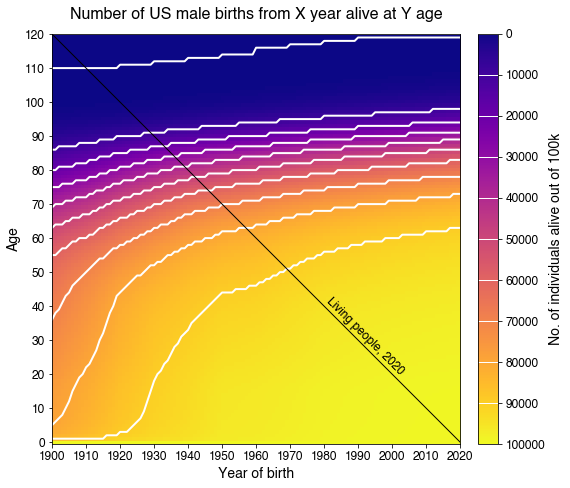

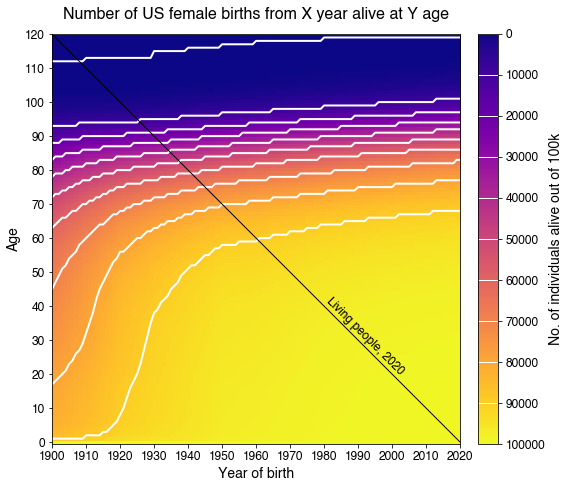

In [4]:
#OPTIONAL DATA VISUALIZATION
showplot = False

#This one's particularly useful for understanding the data,
#defaulting to show.
if 1:
    
    alive_M_t = alive_M.values.astype('float64').T
    alive_F_t = alive_F.values.astype('float64').T
    
    #Exploratory comparison:
    fig = plt.figure(figsize=[8,8])
    ax = plt.subplot(111, aspect='equal')
    cax = ax.imshow(alive_M_t, cmap='plasma')
    plt.title('Number of US male births from X year alive at Y age', pad=15)
    plt.ylabel('Age')
    plt.xlabel('Year of birth')

    #Get contours:
    contours_alive = np.zeros([alive_M_t.shape[1], 11])
    alive_num = []
    for n in range(10):

        #Note: Below method for finding first index at which the comparison
        #is true is not necessarily the best, it may cause spotty outputs for
        #unsorted data for example, but allows multidimensional comparison 
        #natively with use of the 'axis' variable. Where, nonzero, and
        #searchsorted use a 1D array and would have to be reindexed. Would be
        #good flatten/rebuild matrix practice at some point in the future.
        #
        #Good discussion here: 
        #https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

        #Find first index at which fewer than X people are alive:
        contours_alive[:,n] = np.argmax(alive_M_t < (100000 - n*10000), axis=0)

        alive_num.append(100000 - n*10000)

    contours_alive[:,10] = np.argmax(alive_M_t < 1, axis=0)
    contours_alive[contours_alive[:,10]==0, 10] = np.max(contours_alive[:,10])
    alive_num.append(0)

    plt.plot(contours_alive[:,1:], color=[1,1,1], linewidth=2)

    ax.plot([120,0],[0,120],'k',linewidth=1)
    txtemp = ax.text(80,20, 'Living people, 2020', size=12, rotation=-45)

    plt.ylim([-0.5,119.5])
    plt.xlim([.5,120])

    ax.set_xticks(np.arange(0,121,10))
    ax.set_xticklabels((np.arange(0,121,10) + 1900).astype('str'))
    ax.set_yticks(np.arange(0,121,10))


    cbar = fig.colorbar(cax, 
                        ticks=alive_num, fraction=0.046, pad=0.04,
                        label='No. of individuals alive out of 100k',)
    cbar.ax.set_yticklabels(alive_num)  # vertically oriented colorbar
    cbar_lims = cbar.ax.get_xlim()
    cbar.ax.invert_yaxis()
    cbar.ax.hlines(alive_num, cbar_lims[0], cbar_lims[1], colors='w', linewidth=1)
    fig.set_facecolor('white')

    plt.show()


    #Redo for F:
    fig = plt.figure(figsize=[8,8])
    ax = plt.subplot(111, aspect='equal')
    cax = ax.imshow(alive_F_t, cmap='plasma')
    plt.title('Number of US female births from X year alive at Y age', pad=15)
    plt.ylabel('Age')
    plt.xlabel('Year of birth')

    #Get contours:
    contours_alive = np.zeros([alive_F_t.shape[1], 11])
    alive_num = []
    for n in range(10):

        #Note: Below method for finding first index at which the comparison
        #is true is not necessarily the best, it may cause spotty outputs for
        #unsorted data for example, but allows multidimensional comparison 
        #natively with use of the 'axis' variable. Where, nonzero, and
        #searchsorted use a 1D array and would have to be reindexed. Would be
        #good flatten/rebuild matrix practice at some point in the future.
        #
        #Good discussion here: 
        #https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value

        #Find first index at which fewer than X people are alive:
        contours_alive[:,n] = np.argmax(alive_F_t < (100000 - n*10000), axis=0)

        alive_num.append(100000 - n*10000)

    contours_alive[:,10] = np.argmax(alive_F_t < 1, axis=0)
    contours_alive[contours_alive[:,10]==0,10] = np.max(contours_alive[:,10])
    alive_num.append(0)

    plt.plot(contours_alive[:,1:], color=[1,1,1], linewidth=2)

    ax.plot([120,0],[0,120],'k',linewidth=1)
    txtemp = ax.text(80,20, 'Living people, 2020', size=12, rotation=-45)

    plt.ylim([-0.5,119.5])
    plt.xlim([.5,120])

    ax.set_xticks(np.arange(0,121,10))
    ax.set_xticklabels((np.arange(0,121,10) + 1900).astype('str'))
    ax.set_yticks(np.arange(0,121,10))


    cbar = fig.colorbar(cax, 
                        ticks=alive_num, fraction=0.046, pad=0.04,
                        label='No. of individuals alive out of 100k',)
    cbar.ax.set_yticklabels(alive_num)  # vertically oriented colorbar
    cbar.ax.invert_yaxis()
    cbar_lims = cbar.ax.get_xlim()
    cbar.ax.hlines(alive_num, cbar_lims[0], cbar_lims[1], colors='w', linewidth=1)
    fig.set_facecolor('white')

    plt.show()

In [6]:
#Get the yearly total of all names (including sub-5) from Social Security 
#Admin, by year (useful for normalization)
#
#https://www.ssa.gov/oact/babynames/numberUSbirths.html

#Gets the data raw from the website and pickles it.

reload = False

if reload:
    response = requests.get('https://www.ssa.gov/oact/babynames/numberUSbirths.html')
    totalnames_table = pd.read_html(response.text, index_col='Year of birth')
    totalnames_table = totalnames_table[0]
    totalnames_table.to_pickle('Total_soc_cards.pkl')
else:
    totalnames_table = pd.read_pickle('Total_soc_cards.pkl')

In [7]:
#Load the year-of-birth data, in "yobYYYY.txt" format csv files.
#
#Data source: https://www.ssa.gov/OACT/babynames/limits.html,
#has national zip file that unpacks to the files below.

os.chdir('../Names/names_w2019')
current_dir = os.listdir()

names_temp = []
for ftemp in current_dir:
    if ftemp[-3:] == 'txt':
        dftemp = pd.read_csv(ftemp, names=['Name','Sex','Number'])
        dftemp['Year'] = int(ftemp[3:-4])
        names_temp.append(dftemp)
        
names_df = pd.concat(names_temp)
names_df.info()

os.chdir('..')
#These births will be called "nameset births" from here on out.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1989401 entries, 0 to 31953
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Sex     object
 2   Number  int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 75.9+ MB


In [8]:
#Reset the indexes to unduplicate them, since each stack was indexed 
#separately; keeping the old indices is handy though, so default
#'drop = false' option is kept.

#Yes, the sorting matters. It makes plotting way easier later on, and
#I could definitely use it to speed up the name structure indexing. 

names_df = names_df.reset_index().sort_values(['Name','Year'])

names_df

,index,Name,Sex,Number,Year
448113,32927,Aaban,M,5,2007
1658007,31173,Aaban,M,6,2009
622048,27952,Aaban,M,9,2010
542562,26567,Aaban,M,11,2011
342293,26559,Aaban,M,11,2012
...,...,...,...,...,...
127430,29729,Zyvon,M,7,2015
611071,16975,Zyyanna,F,6,2010
61074,31299,Zyyon,M,6,2014
628177,34081,Zzyzx,M,5,2010


In [9]:
#Above is raw, not controlled for population or births. What was 
#the total as a fraction of the year's name births? Currently only
#using the over-5-names as the core comparison. Could pull from
#the social security total above, here, in future improvements.

year_total = names_df.groupby('Year').sum()

#Join year_total w/ names_df to get what fraction of total births
#that year made up of the given name/sex pair:
names_df = pd.merge(left=names_df, right=totalnames_table, 
                    left_on='Year', right_on='Year of birth', 
                    how='left')
names_df['Fraction'] = names_df['Number']/names_df['Total']

#Not normalizing to number of male or female births, just total.
#Possible future improvement, since likelihood of registering
#appears to have had some sex bias early on. 
names_df.drop(columns=['Male','Female','Total'], inplace=True)

In [10]:
names_df.head()

,index,Name,Sex,Number,Year,Fraction
0,32927,Aaban,M,5,2007,0.000001
1,31173,Aaban,M,6,2009,0.000001
2,27952,Aaban,M,9,2010,0.000002
3,26567,Aaban,M,11,2011,0.000003
4,26559,Aaban,M,11,2012,0.000003


In [11]:
#Calculate total number of births for each name:
totalbirths_byname = names_df[['Name','Sex','Number']].groupby(['Name','Sex']).sum()

trimvalue = 20
#Limit dataset to names that had more than 20 total
#people with that name:
keepnames = totalbirths_byname[totalbirths_byname['Number'] > trimvalue]

#Join on name/sex pairs to keep only ones included above
names_df_trim = pd.merge(left=names_df, right=keepnames, on=['Name','Sex'], how='inner')
#Handling number column ambiguity, not pretty but works fine
names_df_trim['Number'] = names_df_trim['Number_x']
names_df_trim.drop(columns=['Number_x', 'Number_y'], inplace=True)
val1 = len(names_df.groupby(['Name','Sex']).size())
val2 = len(names_df_trim.groupby(['Name','Sex']).size())
val1a = len(names_df)
val2a = len(names_df_trim)

#Display results
print('Pretrim -> posttrim, minimum {} births:\n'.format(trimvalue))
print('Names (total of M and F separately):')
print(val1, '->', val2)
print('Name/year records:')
print(val1a, '->', val2a)
print('\nRemoves {:.2f} of names while only removing {:.3f} of total birth records.'.format((val1-val2)/val1, (val1a-val2a)/val1a))

Pretrim -> posttrim, minimum 20 births:

Names (total of M and F separately):
110386 -> 69822
Name/year records:
1989401 -> 1925530

Removes 0.37 of names while only removing 0.032 of total birth records.


In [12]:
#Cache
names_df_trim.to_pickle('names_df_trim.pkl')

In [13]:
#Grab the individual names
names_list = names_df_trim['Name'].unique()

In [14]:
#OPTIONAL VISUALIZATION

if showplot:
    #Show births trajectory for a random name:
    tgtind = (names_df['Name']=='Nanette') & (names_df['Sex']=='F')
    subset = names_df[tgtind].sort_values('Year')
    fig, axs = plt.subplots(1,2,figsize=[10,5])
    axs[0].plot(subset['Year'], subset['Number'])
    axs[1].plot(subset['Year'], subset['Fraction'])
    plt.tight_layout()
    plt.show()

In [15]:
#Data analysis check:
#Calculate how many unique names per year (useful double check for trim)

numnames = []
for year in names_df['Year'].sort_values().unique():
    nn_y = year
    nn_b = len(names_df[names_df['Year']==year]['Name'].unique())
    nn_c = len(names_df_trim[names_df_trim['Year']==year]['Name'].unique())
    numnames.append([nn_y, nn_b, nn_c])
    
numnames = pd.DataFrame(numnames, columns=['Year','N_names_tot','N_names_trim']).set_index('Year')
numnames

,N_names_tot,N_names_trim
Year,,
1880,1889,1888
1881,1830,1827
1882,2012,2008
1883,1962,1957
1884,2158,2151
1885,2139,2136
1886,2225,2219
1887,2215,2213
1888,2454,2447


### Names dataset is a pretty good representation of all births, starting around 1915

The names dataset we're working with, to review, is published by the Social Security Administration and includes all recorded baby names with 5 or more births during that year. This dataset does a reasonably good job tracking total births starting around 1915. By 1920, the names database was covering at least 75\% of all births in the census estimates, up to 97.5\% in 1960. Since then, the coverage has declined; given the striking increase in total number of unique names observed per year, it is likely that some of that decline reflects increasing numbers of excluded unique or near-unique names.

### Pre-1915 data has limited coverage, but we'll assume it still reflects name distribution
Most of the data is good enough to work with, but pre-1915, we'll be relying partly on extrapolation. For the purposes of this analysis, I'll assume that the baby names recorded from 1880 to 1915 accurately represent the overall distribution of names in the population. There are a variety of reasons we might expect that assumption to be flawed, such as bias from which states were reporting at the time, immigration recency affecting likelihood of registration, urban/rural differences, etc., but the distribution of the most popular baby names before and after the big registration spike in the 1910s is pretty similar, so there's a good chance it doesn't make a *huge* difference at least.

If I were performing this analysis in 30 years, I'd probably just skip that earlier data, but if we skip it now, we have very few years with reasonably-complete birth cohort data.

## Living names:

The goal: A dataset of the names of currently living US-born people for each year, which will cover people born 1880 to the current day. The number of living people over 90 has historically been small, so we'll have a fairly complete population estimate of US-born names starting in 1970 or so. 

The actuarial table estimates start in 1900, and include decade-by-decade estimates. I'll use a few assumptions here: 

1. Assumption: All years between the decade estimates (i.e. 1901-1909) can be approximated by linear interpolation. This should be pretty accurate, since the decade data includes single-year resolution of cohort life expectancy. This interpolation is already performed in the loaded tables. 
2. Assumption: All birth cohorts from 1880-1899 follow the 1900 lifespan pattern, scaled to the expected values found in the 1900 period life table. This is likely to be inaccurate given how fast childhood mortality was changing after 1900, but will be partially corrected by normalizing to known values in the 1900 dataset, like number of individuals who are 20 in 1900. 
3. Assumption: Names do not predict actuarial outcomes. Likely to be somewhat inaccurate, since names are associated with demographics, but it's both less difficult and less prone to error than attempting to categorize names by demographics.

In [16]:
#Reprocessing actuarial data:

#Assume 1880-1900 lifespans have the same trajectory as 1900, then 
#normalize the starting births to match the number from that cohort
#who were alive in 1900. We can get that data from the period life
#tables; they predict how long someone will live based on how many
#people who are X age in the previous year are still alive.

alive_F_prescale = alive_F.copy() #Keep originals for reference
alive_M_prescale = alive_M.copy() #Keep originals for reference

#Add rows for 1880-1899:

#Could avoid loop, but it's fast anyway.
for year in np.arange(1880, 1900):
    alive_F.loc[year,:] = alive_F.loc[1900,:]
    alive_F_prescale.loc[year,:] = alive_F_prescale.loc[1900,:]
    #Multiply that year's aliveness vector by a scale number that
    #makes the aliveness in 1900 line up with the "p" (period)
    #data for 1900, which is based on past survival.
    alive_F.loc[year,:] = alive_F.loc[year,:] * (alive_F_p.loc[1900,1900-year-1])/(alive_F.loc[1900,1900-year-1])
alive_F = alive_F.sort_index()
alive_F_prescale = alive_F_prescale.sort_index()

for year in np.arange(1880, 1900):
    alive_M.loc[year,:] = alive_M.loc[1900,:]
    alive_M_prescale.loc[year,:] = alive_M_prescale.loc[1900,:]
    alive_M.loc[year,:] = alive_M.loc[year,:] * (alive_M_p.loc[1900,1900-year-1])/(alive_M.loc[1900,1900-year-1])
alive_M = alive_M.sort_index()
alive_M_prescale = alive_M_prescale.sort_index()

#In short, the alive_X structures are the number of people born in [row]
#year that have/will survive for [col] years. I'm using this "cohort data" 
#rather than period data, since I'm most interested in tracking individual
#lives across the timespan. THIS WILL MEAN THAT THE LIFE TABLE DOES NOT
#START AT 100,000 FOR THESE VALUES. That won't cause any analysis problems, 
#but should be kept in mind because it's nonstandard for actuarial data.

In [17]:
#Display the effect of this control for period life expectancy
#SUMMARY: Small but noticeable difference, a couple percent.

if showplot:
    plt.figure(figsize=[12,10])
    plt.subplot(2,2,1)
    plt.imshow(alive_F.astype('float64').T)
    plt.title('1800 normalized to period-1900 age vals')
    plt.subplot(2,2,2)
    plt.imshow(alive_F_prescale.astype('float64').T)
    plt.title('1880 set to equal 1900')
    plt.subplot(2,2,3)
    plt.imshow(alive_F_prescale.astype('float64').T - alive_F.astype('float64').T, vmax=5000)
    plt.title('Difference x20 (peak diff on the order of 2.5k/100k)')
    plt.show()

### The core reprocessing loop: make it a matrix instead of a dataframe

In short, what I've got to start with is rows for each year when a name had more than 5 births. This isn't great for fast analysis, so I'm converting to a matrix and multiplying it with the actuarial data to get how many people of a given name/sex pair are likely to have been alive in each year. There are some coding notes on speed below. Can likely be done more efficiently with for example multiple layers of sparse matrices, but this works, and the large matrix will not be referenced directly in the final version of the project. 

In [18]:
#Define functions/vars to build the big matrix of aliveness:

#It may be possible to pull this off with joins or array ops,
#but there's a LOT of looking at multiple rows to solve for
#a single set of values. Could also be inefficient.

#Most likely, the way to get this ACTUALLY fast is to pre-sort
#by name and year, then use find operations to grab ranges of 
#data at a time. Match 2 items, versus matching 140. But since
#I can save/load the data faster than I could process it out,
#this one-time 5-minute run (for M and F total) is fine. 

#Variables: 
#    nyears, total range of years of birth data (140, through 2019)
#    ndeath, total range of alive_X data for each year (120)
#    nyearsmax, last projected year (2050 - 1880)
nyears = len(numnames)
ndeath = alive_M.shape[1] #once
nyearsmax = 2050-1880

#Rebuild the alive matrix to sit across the target years:
#For each year's row, start the alive data from that year
#at that year's index, instead of at zero.
alive_M_re = np.zeros([nyears, nyears+ndeath])
for n in np.arange(0,nyears):
    tgt_year = n+1880
    alive_M_re[n, n:ndeath+n] = alive_M.loc[tgt_year,:]
alive_F_re = np.zeros([nyears, nyears+ndeath])
for n in np.arange(0,nyears):
    tgt_year = n+1880
    alive_F_re[n, n:ndeath+n] = alive_F.loc[tgt_year,:]
    

baseyear_df = pd.DataFrame(index=np.arange(1880,2020))

def gen_name_alive(name, sex, namedf, base_alive):
    #Non-passed vars used:
    #    baseyear_df
    #    nyears
    #    ndeath
    #    nyearsmax
    
    tgt_ind = (namedf['Name']==name) & (namedf['Sex']==sex)

    name_chunk = namedf[tgt_ind]
    name_chunk = name_chunk.set_index('Year')
    currentbirths = baseyear_df.join(name_chunk['Number']).fillna(0).values.T
    
    alive_vec = np.matmul(currentbirths, base_alive[:,:nyearsmax])
    alive_arr = base_alive[:,:nyearsmax] * np.tile(currentbirths.T,[1,nyearsmax])
    return alive_vec, alive_arr, currentbirths


#NOTABLY FASTER than using this 3-way join method:

# def gen_name_alive(name, sex, namedf, base_alive):
#     #Make base year array
#     baseyear_df = pd.DataFrame(np.arange(1880,2020), columns=['Year'])
#     baseyear_df['Name'] = name
#     baseyear_df['Sex'] = sex
#     baseyear_df.set_index(['Year','Name','Sex'], inplace=True)
#     #The time-consuming line (everything else totals <.5msec):
#     currentbirths = baseyear_df.join(namedf['Number']).fillna(0).values.T
#
#     alive_vec = np.matmul(currentbirths, base_alive)
#     alive_vec = alive_vec[:,:nyearsmax]
#     alive_arr = base_alive[:,:nyearsmax] * np.tile(currentbirths.T,[1,nyearsmax])
#     return alive_vec, alive_arr, currentbirths

In [19]:
#Takes 3 minutes.

#Why am I splitting up the name chunks? Partly processing,
#partly making it easier to tell apart "Emily", the female
#name, from "Emily", the male name. Yes, there are a lot of
#names where there is gender overlap. I want to count them
#separately, since they can represent separate trends. 

#Could function this, but it uses and generates a pile of
#variables that I want to keep for both cases, and only 
#happens twice. 

#'names_F', full dataset with only female names
#'nameset_F', full list of female names
#'tempyears', how many years in the dataset
names_F = names_df_trim[names_df_trim['Sex']=='F'].sort_values('Name')
nameset_F = names_F['Name'].unique()
tempyears = names_F['Year'].unique()

#Array dimensions: Number of names, number of initial years, max year
namelife_F_full = np.zeros([len(nameset_F), nyears, nyearsmax])
namelife_F_base = np.zeros([len(nameset_F), nyearsmax])
namebirth_F = np.zeros([len(nameset_F), nyears])
namelife_F_name = []

print('Number of names: ' + str(len(nameset_F)))

namecount = 0

starttime1 = time.time()
starttime2 = time.time()
print('\nBEGIN:')

binsize = 100
#Make the bin indexes:
bin_indexes = np.arange(0,len(nameset_F),binsize)
if (len(nameset_F)%binsize):
    bin_indexes = np.append(bin_indexes,len(nameset_F)+1)

for n in range(len(bin_indexes)-1):
    #Grab this bin's set of data:
    #print(n)
    #print(bin_indexes[n], bin_indexes[n+1])
    bininds = [bin_indexes[n], bin_indexes[n+1]]
    nameset_sub = nameset_F[bininds[0]:bininds[1]]
    names_F_sub = names_F[names_F['Name'].isin(nameset_sub)]
    
    for nameind in np.arange(0,len(nameset_sub)):
        
        nametemp = nameset_sub[nameind]
        a_v, a_a, c_b = gen_name_alive(nametemp, 'F', names_F_sub, alive_F_re)
        
        namelife_F_base[namecount,:] = a_v
        namelife_F_full[namecount,:,:] = a_a
        namebirth_F[namecount,:] = c_b
        namelife_F_name.append(nametemp)
        
        namecount += 1
        
    print('bininds ' + str(bininds) + ', ' + 
          str(round(time.time() - starttime1, 3)) + 's tot, ' + 
          str(round(time.time() - starttime2, 3)) + 's per ' + str(binsize) + '-loop')
    starttime2 = time.time()

#Scale for base population of 100000 in actuarial data:
namelife_F_full = (namelife_F_full/100000).astype('int32')
namelife_F_base = namelife_F_base/100000
namelife_F_name = pd.Series(namelife_F_name)

Number of names: 43177

BEGIN:
bininds [0, 100], 0.357s tot, 0.357s per 100-loop
bininds [100, 200], 0.722s tot, 0.365s per 100-loop
bininds [200, 300], 1.078s tot, 0.356s per 100-loop
bininds [300, 400], 1.433s tot, 0.355s per 100-loop
bininds [400, 500], 1.796s tot, 0.363s per 100-loop
bininds [500, 600], 2.156s tot, 0.36s per 100-loop
bininds [600, 700], 2.52s tot, 0.364s per 100-loop
bininds [700, 800], 2.879s tot, 0.359s per 100-loop
bininds [800, 900], 3.257s tot, 0.377s per 100-loop
bininds [900, 1000], 3.652s tot, 0.395s per 100-loop
bininds [1000, 1100], 4.011s tot, 0.359s per 100-loop
bininds [1100, 1200], 4.404s tot, 0.393s per 100-loop
bininds [1200, 1300], 4.765s tot, 0.361s per 100-loop
bininds [1300, 1400], 5.14s tot, 0.375s per 100-loop
bininds [1400, 1500], 5.514s tot, 0.375s per 100-loop
bininds [1500, 1600], 5.875s tot, 0.361s per 100-loop
bininds [1600, 1700], 6.282s tot, 0.407s per 100-loop
bininds [1700, 1800], 6.645s tot, 0.363s per 100-loop
bininds [1800, 1900],

bininds [14900, 15000], 67.585s tot, 0.407s per 100-loop
bininds [15000, 15100], 68.023s tot, 0.438s per 100-loop
bininds [15100, 15200], 68.46s tot, 0.437s per 100-loop
bininds [15200, 15300], 68.899s tot, 0.439s per 100-loop
bininds [15300, 15400], 69.382s tot, 0.482s per 100-loop
bininds [15400, 15500], 69.818s tot, 0.436s per 100-loop
bininds [15500, 15600], 70.213s tot, 0.394s per 100-loop
bininds [15600, 15700], 70.601s tot, 0.388s per 100-loop
bininds [15700, 15800], 70.995s tot, 0.394s per 100-loop
bininds [15800, 15900], 71.38s tot, 0.385s per 100-loop
bininds [15900, 16000], 71.804s tot, 0.423s per 100-loop
bininds [16000, 16100], 72.191s tot, 0.387s per 100-loop
bininds [16100, 16200], 72.588s tot, 0.397s per 100-loop
bininds [16200, 16300], 72.984s tot, 0.396s per 100-loop
bininds [16300, 16400], 73.364s tot, 0.38s per 100-loop
bininds [16400, 16500], 73.77s tot, 0.406s per 100-loop
bininds [16500, 16600], 74.192s tot, 0.422s per 100-loop
bininds [16600, 16700], 74.576s tot

bininds [29300, 29400], 126.292s tot, 0.368s per 100-loop
bininds [29400, 29500], 126.667s tot, 0.374s per 100-loop
bininds [29500, 29600], 127.06s tot, 0.393s per 100-loop
bininds [29600, 29700], 127.461s tot, 0.401s per 100-loop
bininds [29700, 29800], 127.829s tot, 0.368s per 100-loop
bininds [29800, 29900], 128.192s tot, 0.364s per 100-loop
bininds [29900, 30000], 128.548s tot, 0.355s per 100-loop
bininds [30000, 30100], 128.918s tot, 0.37s per 100-loop
bininds [30100, 30200], 129.313s tot, 0.395s per 100-loop
bininds [30200, 30300], 129.68s tot, 0.366s per 100-loop
bininds [30300, 30400], 130.059s tot, 0.38s per 100-loop
bininds [30400, 30500], 130.43s tot, 0.37s per 100-loop
bininds [30500, 30600], 130.801s tot, 0.372s per 100-loop
bininds [30600, 30700], 131.195s tot, 0.393s per 100-loop
bininds [30700, 30800], 131.561s tot, 0.366s per 100-loop
bininds [30800, 30900], 131.934s tot, 0.374s per 100-loop
bininds [30900, 31000], 132.334s tot, 0.399s per 100-loop
bininds [31000, 3110

In [20]:
#Takes under 2 minutes.

#'names_M', full dataset with only male names
#'nameset_M', full list of male names
#'tempyears', how many years in the dataset
names_M = names_df_trim[names_df_trim['Sex']=='M'].sort_values('Name')
nameset_M = names_M['Name'].unique()
tempyears = names_M['Year'].unique()

#Array dimensions: Number of names, number of initial years, max year
namelife_M_full = np.zeros([len(nameset_M), nyears, nyearsmax])
namelife_M_base = np.zeros([len(nameset_M), nyearsmax])
namebirth_M = np.zeros([len(nameset_M), nyears])
namelife_M_name = []

print('Number of names: ' + str(len(nameset_M)))

namecount = 0

starttime1 = time.time()
starttime2 = time.time()
print('\nBEGIN:')

binsize = 100
#Make the bin indexes:
bin_indexes = np.arange(0,len(nameset_M),binsize)
if (len(nameset_M)%binsize):
    bin_indexes = np.append(bin_indexes,len(nameset_M)+1)

for n in range(len(bin_indexes)-1):
    #Grab this bin's set of data:
    bininds = [bin_indexes[n], bin_indexes[n+1]]
    nameset_sub = nameset_M[bininds[0]:bininds[1]]
    names_M_sub = names_M[names_M['Name'].isin(nameset_sub)]
    
    for nameind in np.arange(0,len(nameset_sub)):
        
        nametemp = nameset_sub[nameind]
        a_v, a_a, c_b = gen_name_alive(nametemp, 'M', names_M_sub, alive_M_re)
        
        namelife_M_base[namecount,:] = a_v
        namelife_M_full[namecount,:,:] = a_a
        namebirth_M[namecount,:] = c_b
        namelife_M_name.append(nametemp)
        
        namecount += 1
        
    print('bininds ' + str(bininds) + ', ' + 
          str(round(time.time() - starttime1, 3)) + 's tot, ' + 
          str(round(time.time() - starttime2, 3)) + 's per ' + str(binsize) + '-loop')
    starttime2 = time.time()

#Scale for base population of 100000 in actuarial data:
namelife_M_full = (namelife_M_full/100000).astype('int32')
namelife_M_base = namelife_M_base/100000
namelife_M_name = pd.Series(namelife_M_name)

Number of names: 26645

BEGIN:
bininds [0, 100], 0.346s tot, 0.346s per 100-loop
bininds [100, 200], 0.705s tot, 0.358s per 100-loop
bininds [200, 300], 1.077s tot, 0.372s per 100-loop
bininds [300, 400], 1.437s tot, 0.36s per 100-loop
bininds [400, 500], 1.778s tot, 0.341s per 100-loop
bininds [500, 600], 2.12s tot, 0.342s per 100-loop
bininds [600, 700], 2.461s tot, 0.341s per 100-loop
bininds [700, 800], 2.819s tot, 0.358s per 100-loop
bininds [800, 900], 3.187s tot, 0.368s per 100-loop
bininds [900, 1000], 3.543s tot, 0.356s per 100-loop
bininds [1000, 1100], 3.902s tot, 0.359s per 100-loop
bininds [1100, 1200], 4.243s tot, 0.341s per 100-loop
bininds [1200, 1300], 4.588s tot, 0.344s per 100-loop
bininds [1300, 1400], 4.943s tot, 0.355s per 100-loop
bininds [1400, 1500], 5.292s tot, 0.349s per 100-loop
bininds [1500, 1600], 5.652s tot, 0.36s per 100-loop
bininds [1600, 1700], 5.994s tot, 0.342s per 100-loop
bininds [1700, 1800], 6.363s tot, 0.368s per 100-loop
bininds [1800, 1900],

bininds [14900, 15000], 53.363s tot, 0.337s per 100-loop
bininds [15000, 15100], 53.694s tot, 0.331s per 100-loop
bininds [15100, 15200], 54.051s tot, 0.357s per 100-loop
bininds [15200, 15300], 54.383s tot, 0.332s per 100-loop
bininds [15300, 15400], 54.74s tot, 0.356s per 100-loop
bininds [15400, 15500], 55.086s tot, 0.346s per 100-loop
bininds [15500, 15600], 55.458s tot, 0.372s per 100-loop
bininds [15600, 15700], 55.813s tot, 0.355s per 100-loop
bininds [15700, 15800], 56.17s tot, 0.357s per 100-loop
bininds [15800, 15900], 56.535s tot, 0.365s per 100-loop
bininds [15900, 16000], 56.901s tot, 0.366s per 100-loop
bininds [16000, 16100], 57.25s tot, 0.349s per 100-loop
bininds [16100, 16200], 57.622s tot, 0.372s per 100-loop
bininds [16200, 16300], 57.987s tot, 0.364s per 100-loop
bininds [16300, 16400], 58.361s tot, 0.374s per 100-loop
bininds [16400, 16500], 58.714s tot, 0.353s per 100-loop
bininds [16500, 16600], 59.066s tot, 0.352s per 100-loop
bininds [16600, 16700], 59.401s to

In [21]:
#Arrays are about 7 percent nonzero, but very annoying to store
#as a sparse matrix, since they're 3D. I'll just leave them, but
#consider for future compression.

print(round(np.count_nonzero(namelife_F_full)/namelife_F_full.size,3))

0.074


In [22]:
#Note that variables are also cached in several earlier locations. 

np.save('namelife_F_full.npy',namelife_F_full)
np.save('namelife_F_base.npy',namelife_F_base)
np.save('namebirth_F.npy',namebirth_F)
namelife_F_name.to_pickle('namelife_F_name.pkl')

np.save('namelife_M_full.npy',namelife_M_full)
np.save('namelife_M_base.npy',namelife_M_base)
np.save('namebirth_M.npy',namebirth_M)
namelife_M_name.to_pickle('namelife_M_name.pkl')